<a href="https://colab.research.google.com/github/meysam-kazemi/drive-unet/blob/main/FR_Unet_patches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/RETINAL/

/content/drive/.shortcut-targets-by-id/19v_-z68QIom5bSkKsoiETI2xN8cPjPox/RETINAL


In [ ]:

%ls

 augment.ipynb                 outputs/
'Copy of unet_patches.ipynb'   presentation.gslides
 datasets/                     seminar_report_finalـ.docx
 drive_dataset.png             test/
 figs/                         test.zip
 figsdrive_dataset.png         training/
 files/                        training.zip
 fr-unet.ipynb                 unet-2.ipynb
 FR-Unet_patches.ipynb         unet.ipynb
 kazemi.doc                    unet_model_image-random-patches-finetune-90-final.pth
 loss_plot.png                 unet_patches.ipynb
 models/                       unet-without-anything.pth
 new_data/


In [ ]:
# Libraries

import os
import time
import random
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from glob import glob
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
import cv2
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

# UTILS

In [ ]:
# Utils

def add_metric_history(metrics, hist):
    for k, _ in hist.items():
      hist[k].append(metrics[k])
    return hist


""" Seeding the randomness. """
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

""" Create a directory. """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

""" Calculate the time taken """
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Data

In [ ]:
# Data

class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index], 0)  # gray scale
        image = image/255.0 ## (512, 512)
        # image = np.transpose(image, (2, 0, 1))  ## (3, 512, 512)
        image = np.expand_dims(image, axis=0)  # (1, 512, 512)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        """ Reading mask """
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = mask/255.0   ## (512, 512)
        mask = np.expand_dims(mask, axis=0) ## (1, 512, 512)
        mask = (mask > 0.5)*1 # binarize
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

# Loss

In [ ]:
# Loss

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

# Metrics

In [ ]:
import numpy as np
import torch
import cv2
from sklearn.metrics import roc_auc_score

def get_metrics(predict, target, threshold=None, predict_b=None):
    predict = torch.sigmoid(predict).cpu().detach().numpy().flatten()
    if predict_b is not None:
        predict_b = predict_b.flatten()
    else:
        predict_b = np.where(predict >= threshold, 1, 0)
    if torch.is_tensor(target):
        target = target.cpu().detach().numpy().flatten()
    else:
        target = target.flatten()
    tp = (predict_b * target).sum()
    tn = ((1 - predict_b) * (1 - target)).sum()
    fp = ((1 - target) * predict_b).sum()
    fn = ((1 - predict_b) * target).sum()
    auc = roc_auc_score(target>0.5, predict)
    acc = (tp + tn) / (tp + fp + fn + tn)
    pre = tp / (tp + fp)
    sen = tp / (tp + fn)
    spe = tn / (tn + fp)
    iou = tp / (tp + fp + fn)
    f1 = 2 * pre * sen / (pre + sen)
    return {
        "AUC": np.round(auc, 4),
        "F1": np.round(f1, 4),
        "Acc": np.round(acc, 4),
        "Sen": np.round(sen, 4),
        "Spe": np.round(spe, 4),
        "Pre": np.round(pre, 4),
        "IOU": np.round(iou, 4),
    }


def count_connect_component(predict, target, threshold=None, connectivity=8):
    if threshold != None:
        predict = torch.sigmoid(predict).cpu().detach().numpy()
        predict = np.where(predict >= threshold, 1, 0)
    if torch.is_tensor(target):
        target = target.cpu().detach().numpy()
    pre_n, _, _, _ = cv2.connectedComponentsWithStats(np.asarray(
        predict, dtype=np.uint8)*255, connectivity=connectivity)
    gt_n, _, _, _ = cv2.connectedComponentsWithStats(np.asarray(
        target, dtype=np.uint8)*255, connectivity=connectivity)
    return pre_n/gt_n

# Unet

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [ ]:
!pip install timm

In [ ]:
from torch import nn
from timm.models.layers import trunc_normal_

class InitWeights_He(object):
    def __init__(self, neg_slope=1e-2):
        self.neg_slope = neg_slope

    def __call__(self, module):
        if isinstance(module, nn.Conv3d) or isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d) or isinstance(module, nn.ConvTranspose3d):
            module.weight = nn.init.kaiming_normal_(module.weight, a=self.neg_slope)
            if module.bias is not None:
                module.bias = nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.Linear):
            trunc_normal_(module.weight, std=self.neg_slope)
            if isinstance(module, nn.Linear) and module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.LayerNorm):
            nn.init.constant_(module.bias, 0)
            nn.init.constant_(module.weight, 1.0)

In [ ]:
class conv(nn.Module):
    def __init__(self, in_c, out_c, dp=0):
        super(conv, self).__init__()
        self.in_c = in_c
        self.out_c = out_c
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.Dropout2d(dp),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.Dropout2d(dp),
            nn.LeakyReLU(0.1, inplace=True))


    def forward(self, x):
        return self.conv(x)


class feature_fuse(nn.Module):
    def __init__(self, in_c, out_c):
        super(feature_fuse, self).__init__()
        self.conv11 = nn.Conv2d(
            in_c, out_c, kernel_size=1, padding=0, bias=False)
        self.conv33 = nn.Conv2d(
            in_c, out_c, kernel_size=3, padding=1, bias=False)
        self.conv33_di = nn.Conv2d(
            in_c, out_c, kernel_size=3, padding=2, bias=False, dilation=2)
        self.norm = nn.BatchNorm2d(out_c)

    def forward(self, x):
        x1 = self.conv11(x)
        x2 = self.conv33(x)
        x3 = self.conv33_di(x)
        out = self.norm(x1+x2+x3)
        return out


class up(nn.Module):
    def __init__(self, in_c, out_c, dp=0):
        super(up, self).__init__()
        self.up = nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=2,
                               padding=0, stride=2, bias=False),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.1, inplace=False))

    def forward(self, x):
        x = self.up(x)
        return x


class down(nn.Module):
    def __init__(self, in_c, out_c, dp=0):
        super(down, self).__init__()
        self.down = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=2,
                      padding=0, stride=2, bias=False),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.1, inplace=True))

    def forward(self, x):
        x = self.down(x)
        return x


class block(nn.Module):
    def __init__(self, in_c, out_c,  dp=0, is_up=False, is_down=False, fuse=False):
        super(block, self).__init__()
        self.in_c = in_c
        self.out_c = out_c
        if fuse == True:
            self.fuse = feature_fuse(in_c, out_c)
        else:
            self.fuse = nn.Conv2d(in_c, out_c, kernel_size=1, stride=1)

        self.is_up = is_up
        self.is_down = is_down
        self.conv = conv(out_c, out_c, dp=dp)
        if self.is_up == True:
            self.up = up(out_c, out_c//2)
        if self.is_down == True:
            self.down = down(out_c, out_c*2)

    def forward(self,  x):
        if self.in_c != self.out_c:
            x = self.fuse(x)
        x = self.conv(x)
        if self.is_up == False and self.is_down == False:
            return x
        elif self.is_up == True and self.is_down == False:
            x_up = self.up(x)
            return x, x_up
        elif self.is_up == False and self.is_down == True:
            x_down = self.down(x)
            return x, x_down
        else:
            x_up = self.up(x)
            x_down = self.down(x)
            return x, x_up, x_down


class FR_UNet(nn.Module):
    def __init__(self,  num_classes=1, num_channels=1, feature_scale=2,  dropout=0.2, fuse=True, out_ave=True):
        super(FR_UNet, self).__init__()
        self.out_ave = out_ave
        filters = [64, 128, 256, 512, 1024]
        filters = [int(x / feature_scale) for x in filters]
        self.block1_3 = block(
            num_channels, filters[0],  dp=dropout, is_up=False, is_down=True, fuse=fuse)
        self.block1_2 = block(
            filters[0], filters[0],  dp=dropout, is_up=False, is_down=True, fuse=fuse)
        self.block1_1 = block(
            filters[0]*2, filters[0],  dp=dropout, is_up=False, is_down=True, fuse=fuse)
        self.block10 = block(
            filters[0]*2, filters[0],  dp=dropout, is_up=False, is_down=True, fuse=fuse)
        self.block11 = block(
            filters[0]*2, filters[0],  dp=dropout, is_up=False, is_down=True, fuse=fuse)
        self.block12 = block(
            filters[0]*2, filters[0],  dp=dropout, is_up=False, is_down=False, fuse=fuse)
        self.block13 = block(
            filters[0]*2, filters[0],  dp=dropout, is_up=False, is_down=False, fuse=fuse)
        self.block2_2 = block(
            filters[1], filters[1],  dp=dropout, is_up=True, is_down=True, fuse=fuse)
        self.block2_1 = block(
            filters[1]*2, filters[1],  dp=dropout, is_up=True, is_down=True, fuse=fuse)
        self.block20 = block(
            filters[1]*3, filters[1],  dp=dropout, is_up=True, is_down=True, fuse=fuse)
        self.block21 = block(
            filters[1]*3, filters[1],  dp=dropout, is_up=True, is_down=False, fuse=fuse)
        self.block22 = block(
            filters[1]*3, filters[1],  dp=dropout, is_up=True, is_down=False, fuse=fuse)
        self.block3_1 = block(
            filters[2], filters[2],  dp=dropout, is_up=True, is_down=True, fuse=fuse)
        self.block30 = block(
            filters[2]*2, filters[2],  dp=dropout, is_up=True, is_down=False, fuse=fuse)
        self.block31 = block(
            filters[2]*3, filters[2],  dp=dropout, is_up=True, is_down=False, fuse=fuse)
        self.block40 = block(filters[3], filters[3],
                             dp=dropout, is_up=True, is_down=False, fuse=fuse)
        self.final1 = nn.Conv2d(
            filters[0], num_classes, kernel_size=1, padding=0, bias=True)
        self.final2 = nn.Conv2d(
            filters[0], num_classes, kernel_size=1, padding=0, bias=True)
        self.final3 = nn.Conv2d(
            filters[0], num_classes, kernel_size=1, padding=0, bias=True)
        self.final4 = nn.Conv2d(
            filters[0], num_classes, kernel_size=1, padding=0, bias=True)
        self.final5 = nn.Conv2d(
            filters[0], num_classes, kernel_size=1, padding=0, bias=True)
        self.fuse = nn.Conv2d(
            5, num_classes, kernel_size=1, padding=0, bias=True)
        self.apply(InitWeights_He)

    def forward(self, x):
        x1_3, x_down1_3 = self.block1_3(x)
        x1_2, x_down1_2 = self.block1_2(x1_3)
        x2_2, x_up2_2, x_down2_2 = self.block2_2(x_down1_3)
        x1_1, x_down1_1 = self.block1_1(torch.cat([x1_2, x_up2_2], dim=1))
        x2_1, x_up2_1, x_down2_1 = self.block2_1(
            torch.cat([x_down1_2, x2_2], dim=1))
        x3_1, x_up3_1, x_down3_1 = self.block3_1(x_down2_2)
        x10, x_down10 = self.block10(torch.cat([x1_1, x_up2_1], dim=1))
        x20, x_up20, x_down20 = self.block20(
            torch.cat([x_down1_1, x2_1, x_up3_1], dim=1))
        x30, x_up30 = self.block30(torch.cat([x_down2_1, x3_1], dim=1))
        _, x_up40 = self.block40(x_down3_1)
        x11, x_down11 = self.block11(torch.cat([x10, x_up20], dim=1))
        x21, x_up21 = self.block21(torch.cat([x_down10, x20, x_up30], dim=1))
        _, x_up31 = self.block31(torch.cat([x_down20, x30, x_up40], dim=1))
        x12 = self.block12(torch.cat([x11, x_up21], dim=1))
        _, x_up22 = self.block22(torch.cat([x_down11, x21, x_up31], dim=1))
        x13 = self.block13(torch.cat([x12, x_up22], dim=1))
        if self.out_ave == True:
            output = (self.final1(x1_1)+self.final2(x10) +
                      self.final3(x11)+self.final4(x12)+self.final5(x13))/5
        else:
            output = self.final5(x13)

        return output

In [ ]:
model = FR_UNet().to(0)


In [ ]:
# Read the data and set the parameters

# Train

In [ ]:
""" Seeding """
seeding(42)

""" Load dataset """
# train_x = sorted(glob("./datasets/DRIVE/patches/train/images/*"))
# train_y = sorted(glob("./datasets/DRIVE/patches/train/masks/*"))

# test_x = sorted(glob("./datasets/DRIVE/patches/test/images/*"))
# test_y = sorted(glob("./datasets/DRIVE/patches/test/masks/*"))

train_x = sorted(glob("./datasets/DRIVE/image_random_patches/images/*"))
train_y = sorted(glob("./datasets/DRIVE/image_random_patches/masks/*"))

In [ ]:
""" Hyperparameters """
batch_size = 8
num_epochs = 200
lr = 1e-4

""" Dataset and loader """
train_dataset = DriveDataset(train_x, train_y)
# test_dataset = DriveDataset(test_x, test_y)
validation_split = 0.2
# test_size = int((1 - validation_split) * len(test_dataset))
# valid_size = len(test_dataset) - test_size
# # split dataset to train and valid
# test_dataset, valid_dataset = random_split(test_dataset, [test_size, valid_size])
train_size = int((1 - validation_split) * len(train_dataset))
valid_size = len(train_dataset) - train_size
# split dataset to train and valid
train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

# test_loader = DataLoader(
#     dataset=test_dataset,
#     batch_size=batch_size,
#     shuffle=False,
#     num_workers=2
# )


# print(f"Dataset Size:\n  Train: {len(train_loader)}\n  Valid: {len(valid_loader)}\n  Test: {len(test_loader)}")
print(f"Dataset Size:\n  Train: {len(train_loader)}\n  Valid: {len(valid_loader)}")


Dataset Size:
  Train: 32
  Valid: 8


In [ ]:
# model = model.to(0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=6, verbose=True)
# loss_fn = DiceBCELoss()
loss_fn = DiceLoss()
scaler = torch.amp.GradScaler('cuda')


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
create_dir("outputs/frunet-training-image_random_patches/")

In [ ]:
# sigm = nn.functional.sigmoid
def train(model, loader, optimizer, loss_fn, scale,  amp=True):
    epoch_loss = 0.0

    model.train()
    for x, y in loader:
        x = x.to("cuda")
        y = y.to("cuda")

        optimizer.zero_grad()

        if amp:
            with torch.amp.autocast('cuda'):  # Enable mixed precision
                outputs = model(x)
                loss = loss_fn(outputs, y)

            scaler.scale(loss).backward()  # Scale the loss and backpropagate
            scaler.step(optimizer)  # Step the optimizer
            scaler.update()  # Update the scaler
        else:
            outputs = model(x)
            loss = loss_fn(outputs, y)
            loss.backward()
            optimizer.step()


        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return x,y, outputs, epoch_loss

def evaluate(model, loader, loss_fn, amp=False):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to("cuda", torch.float16)
            y = y.to("cuda", torch.float16)
            if amp:
                with torch.amp.autocast('cuda'):  # Enable mixed precision
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

            else:
                outputs = model(x)
                loss = loss_fn(outputs, y)



            epoch_loss += loss.item()

        epoch_loss = epoch_loss/(len(loader))
    return x,y, outputs, epoch_loss


In [ ]:
torch.cuda.empty_cache()

In [ ]:
num_epochs = 120

In [ ]:
init_epoch = 1

In [ ]:
""" Training the model """
best_valid_loss = float("inf")
history = {'epoch': [], 'train_loss': [], 'valid_loss': [], "time": []}
train_metric_hist = {'AUC':[],'F1':[],'Acc':[],'Sen':[],'Spe':[],'Pre':[],'IOU':[]}
valid_metric_hist = {'AUC':[],'F1':[],'Acc':[],'Sen':[],'Spe':[],'Pre':[],'IOU':[]}

for epoch in range(init_epoch+1, num_epochs+1):
    start_time = time.time()

    x_tr, y_tr, outputs_tr, train_loss = train(model, train_loader, optimizer, loss_fn, scaler, True)
    x_val, y_val, outputs_val, valid_loss = evaluate(model, valid_loader, loss_fn, amp=True)
    # History
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['epoch'].append(epoch)
    ep_time = round(time.time()-start_time, 2)
    history['time'].append(ep_time)

    # metrics
    metric_train = get_metrics(predict=outputs_tr, target=y_tr,threshold=0.5)
    metric_valid = get_metrics(predict=outputs_val, target=y_val, threshold=0.5)

    train_metric_hist = add_metric_history(metric_train, train_metric_hist)
    valid_metric_hist = add_metric_history(metric_valid, valid_metric_hist)

    print(f'Epoch [{epoch}/{num_epochs}] | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f} | Time : {ep_time} s')

    # Save the model and images every 10 epochs
    if (epoch) % 10 == 0:
        state = {
        'history': history,
        'epoch' : epoch,
        'train_metric_history': train_metric_hist,
        'valid_metric_history': valid_metric_hist,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict()
        }
        torch.save(state, "models/frunet_last_epoch_image_random_patches_120.pth")

        # # Save 9 image results
        # folder_path = f'outputs/frunet-training/results/epoch{epoch}/'
        # create_dir(folder_path)
        # save_image(x_val.cpu(), folder_path+'images.png', nrow=2, normalize=True)
        # save_image(y_val.cpu(), folder_path+'original_masks.png', nrow=2, normalize=True)
        # save_image(outputs_val.cpu(), folder_path+'outputs.png', nrow=2, normalize=True)



    # """ Saving the model """
    # if valid_loss < best_valid_loss:
    #     data_str = "\033[33mValid loss improved\033[00m"
    #     print(data_str)

    #     best_valid_loss = valid_loss

    #     state = {
    #     'epoch': epoch,
    #     'model': model.state_dict(),
    #     'optimizer': optimizer.state_dict(),
    #     'scheduler': scheduler.state_dict()
    #     }
    #     torch.save(state, f"models/frunet_best_patches.pth")


Epoch [2/120] | Train Loss: 0.8263 | Valid Loss: 0.8166 | Time : 184.43 s
Epoch [3/120] | Train Loss: 0.7709 | Valid Loss: 0.7224 | Time : 107.24 s
Epoch [4/120] | Train Loss: 0.7364 | Valid Loss: 0.7172 | Time : 106.39 s
Epoch [5/120] | Train Loss: 0.7183 | Valid Loss: 0.6976 | Time : 106.24 s
Epoch [6/120] | Train Loss: 0.7091 | Valid Loss: 0.6819 | Time : 105.83 s
Epoch [7/120] | Train Loss: 0.6989 | Valid Loss: 0.6772 | Time : 106.21 s
Epoch [8/120] | Train Loss: 0.6924 | Valid Loss: 0.6710 | Time : 106.13 s
Epoch [9/120] | Train Loss: 0.6836 | Valid Loss: 0.6630 | Time : 106.02 s
Epoch [10/120] | Train Loss: 0.6770 | Valid Loss: 0.6552 | Time : 106.22 s
Epoch [11/120] | Train Loss: 0.6695 | Valid Loss: 0.6526 | Time : 106.06 s
Epoch [12/120] | Train Loss: 0.6628 | Valid Loss: 0.6371 | Time : 106.2 s
Epoch [13/120] | Train Loss: 0.6550 | Valid Loss: 0.6286 | Time : 105.85 s
Epoch [14/120] | Train Loss: 0.6482 | Valid Loss: 0.6268 | Time : 105.84 s
Epoch [15/120] | Train Loss: 0.639

## test

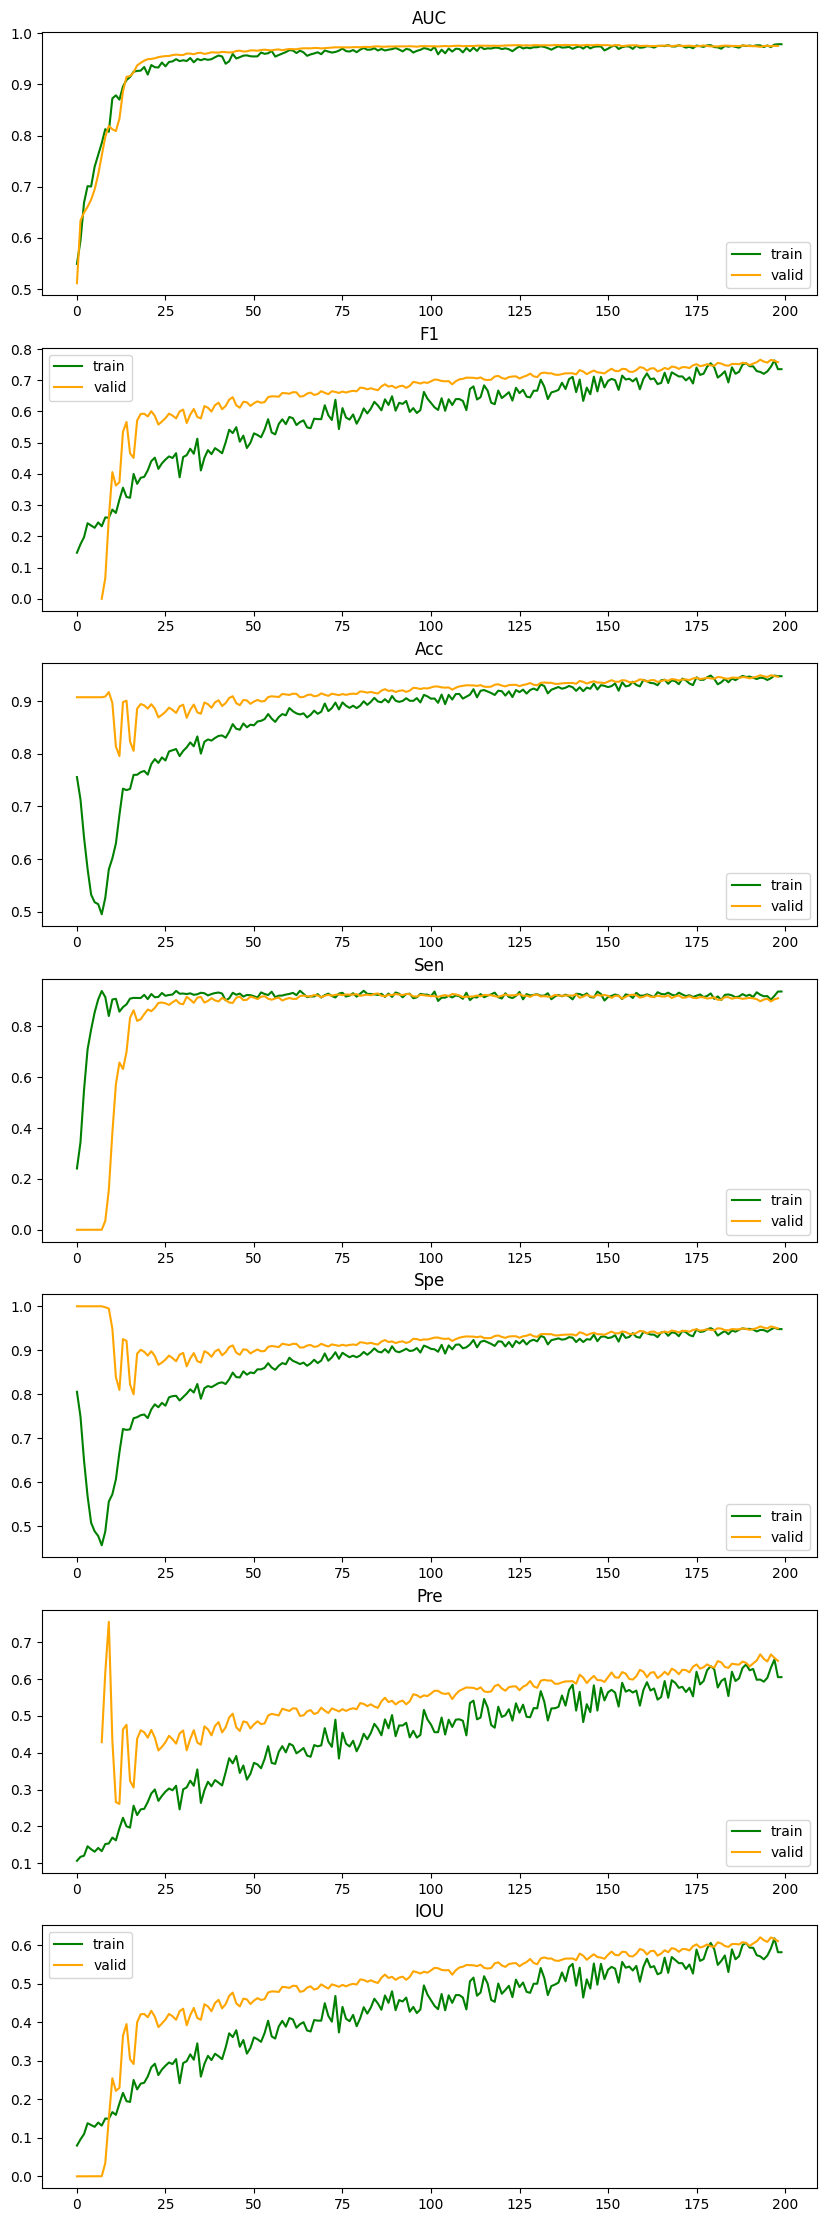

In [ ]:
fig, axs = plt.subplots(7,1, figsize=(10,28))
for i, (k,v) in enumerate(train_metric_hist.items()):
  axs[i].plot(v, c='green', label='train');axs[i].set_title(k)
for i, (k,v) in enumerate(valid_metric_hist.items()):
  axs[i].plot(v, c='orange', label='valid')
  axs[i].legend()

In [ ]:
create_dir("figs")
fig.savefig('figs/frunet-200-poch-patches.png')

In [ ]:
x_test, y_test, outputs_val, test_loss = evaluate(model, test_loader, loss_fn, amp=True)

In [ ]:
test_metric_hist = {'AUC':[],'F1':[],'Acc':[],'Sen':[],'Spe':[],'Pre':[],'IOU':[]}
metric_test = get_metrics(predict=outputs_tr, target=y_tr,threshold=0.5)
test_metric_hist = add_metric_history(metric_test, test_metric_hist)

In [ ]:
test_loss

0.4753881096839905

In [ ]:
test_metric_hist

{'AUC': [0.9784],
 'F1': [0.7354],
 'Acc': [0.9472],
 'Sen': [0.9367],
 'Spe': [0.9481],
 'Pre': [0.6052],
 'IOU': [0.5815]}

In [ ]:
train_metric_hist["IOU"][-3]

0.6176

# Load checkpoints

In [ ]:
MODEL_PATH = "models/frunet_last_epoch_image_random_patches_120.pth"

In [ ]:
model = model.to(0)
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=6, verbose=True)
# loss_fn = DiceBCELoss()
loss_fn = DiceLoss()
scaler = torch.amp.GradScaler('cuda')

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
"""load pre-trained model"""
checkpoint = torch.load(MODEL_PATH)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
scheduler.load_state_dict(checkpoint['scheduler'])
init_epoch = checkpoint['epoch']
valid_metric_hist = checkpoint['valid_metric_history']
train_metric_hist = checkpoint['train_metric_history']
history = checkpoint['history']

<ipython-input-27-d5fd3adb7e56>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH)


# Finetune

In [ ]:
""" Seeding """
seeding(42)

""" Load dataset """
train_x = sorted(glob("./datasets/DRIVE/train-png/images/*"))
train_y = sorted(glob("./datasets/DRIVE/train-png/masks/*"))

test_x = sorted(glob("./datasets/DRIVE/test-png/images/*"))
test_y = sorted(glob("./datasets/DRIVE/test-png/masks/*"))

In [ ]:
""" Hyperparameters """
batch_size = 4
num_epochs = 120
lr = 1e-4
checkpoint_path = "models/unet-patches.pth"

""" Dataset and loader """
train_dataset = DriveDataset(train_x, train_y)
test_dataset = DriveDataset(test_x, test_y)
validation_split = 0.5
test_size = int((1 - validation_split) * len(test_dataset))
valid_size = len(test_dataset) - test_size
# split dataset to train and valid
test_dataset, valid_dataset = random_split(test_dataset, [test_size, valid_size])


train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    # num_workers=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    # num_workers=2
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    # num_workers=2
)


print(f"Dataset Size:\n  Train: {len(train_loader)}\n  Valid: {len(valid_loader)}\n  Test: {len(test_loader)}")

Dataset Size:
  Train: 5
  Valid: 3
  Test: 3


In [ ]:
model = model.to(0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=6, verbose=True)
# loss_fn = DiceBCELoss()
loss_fn = DiceLoss()
scaler = torch.amp.GradScaler('cuda')

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# sigm = nn.functional.sigmoid
def train(model, loader, optimizer, loss_fn, scale,  amp=True):
    epoch_loss = 0.0

    model.train()
    for x, y in loader:
        x = x.to("cuda")
        y = y.to("cuda")

        optimizer.zero_grad()

        if amp:
            with torch.amp.autocast('cuda'):  # Enable mixed precision
                outputs = model(x)
                loss = loss_fn(outputs, y)

            scaler.scale(loss).backward()  # Scale the loss and backpropagate
            scaler.step(optimizer)  # Step the optimizer
            scaler.update()  # Update the scaler
        else:
            outputs = model(x)
            loss = loss_fn(outputs, y)
            loss.backward()
            optimizer.step()


        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return x,y, outputs, epoch_loss

def evaluate(model, loader, loss_fn, amp=False):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to("cuda", torch.float16)
            y = y.to("cuda", torch.float16)
            if amp:
                with torch.amp.autocast('cuda'):  # Enable mixed precision
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

            else:
                outputs = model(x)
                loss = loss_fn(outputs, y)



            epoch_loss += loss.item()

        epoch_loss = epoch_loss/(len(loader))
    return x,y, outputs, epoch_loss


## Load checkpoints

In [ ]:
model = model.to(0)
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
# loss_fn = DiceBCELoss()
loss_fn = DiceLoss()
scaler = torch.amp.GradScaler('cuda')

In [ ]:
"""load pre-trained model"""
checkpoint = torch.load("models/frunet_last_epoch_patches.pth")
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
scheduler.load_state_dict(checkpoint['scheduler'])
init_epoch = checkpoint['epoch']
valid_metric_hist = checkpoint['valid_metric_history']
train_metric_hist = checkpoint['train_metric_history']
history = checkpoint['history']

<ipython-input-32-6fd7a289817d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("models/frunet_last_epoch_patches.pth")


## fine tune loop

In [ ]:
""" Training the model """
best_valid_loss = float("inf")
history = {'epoch': [], 'train_loss': [], 'valid_loss': [], "time": []}
train_metric_hist = {'AUC':[],'F1':[],'Acc':[],'Sen':[],'Spe':[],'Pre':[],'IOU':[]}
valid_metric_hist = {'AUC':[],'F1':[],'Acc':[],'Sen':[],'Spe':[],'Pre':[],'IOU':[]}

num_epochs = 40

for epoch in range(0+1, num_epochs+1):
    start_time = time.time()

    x_tr, y_tr, outputs_tr, train_loss = train(model, train_loader, optimizer, loss_fn, scaler, True)
    x_val, y_val, outputs_val, valid_loss = evaluate(model, valid_loader, loss_fn, amp=True)
    # History
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['epoch'].append(epoch)
    ep_time = round(time.time()-start_time, 2)
    history['time'].append(ep_time)

    # metrics
    metric_train = get_metrics(predict=outputs_tr, target=y_tr,threshold=0.5)
    metric_valid = get_metrics(predict=outputs_val, target=y_val, threshold=0.5)

    train_metric_hist = add_metric_history(metric_train, train_metric_hist)
    valid_metric_hist = add_metric_history(metric_valid, valid_metric_hist)

    print(f'Epoch [{epoch}/{num_epochs}] | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f} | Time : {ep_time} s')

    # Save the model and images every 10 epochs
    if (epoch) % 10 == 0:
        state = {
        'history': history,
        'epoch' : epoch,
        'train_metric_history': train_metric_hist,
        'valid_metric_history': valid_metric_hist,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict()
        }
        torch.save(state, "models/frunet-without-anything-40.pth")

        # # Save 9 image results
        # folder_path = f'outputs/frunet-training/results/epoch{epoch}/'
        # create_dir(folder_path)
        # save_image(x_val.cpu(), folder_path+'images.png', nrow=2, normalize=True)
        # save_image(y_val.cpu(), folder_path+'original_masks.png', nrow=2, normalize=True)
        # save_image(outputs_val.cpu(), folder_path+'outputs.png', nrow=2, normalize=True)


# Plot

Text(0.5, 1.0, 'FR-Unet finetuned')

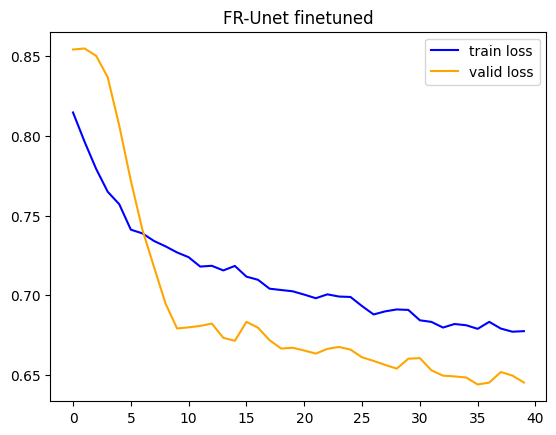

In [ ]:
plt.plot(history['train_loss'], label="train loss", c='b')
plt.plot(history['valid_loss'], label="valid loss", c='orange')
plt.legend()
plt.title("FR-Unet finetuned")
# plt.savefig('figs/FR-Unet-finetuned.png')

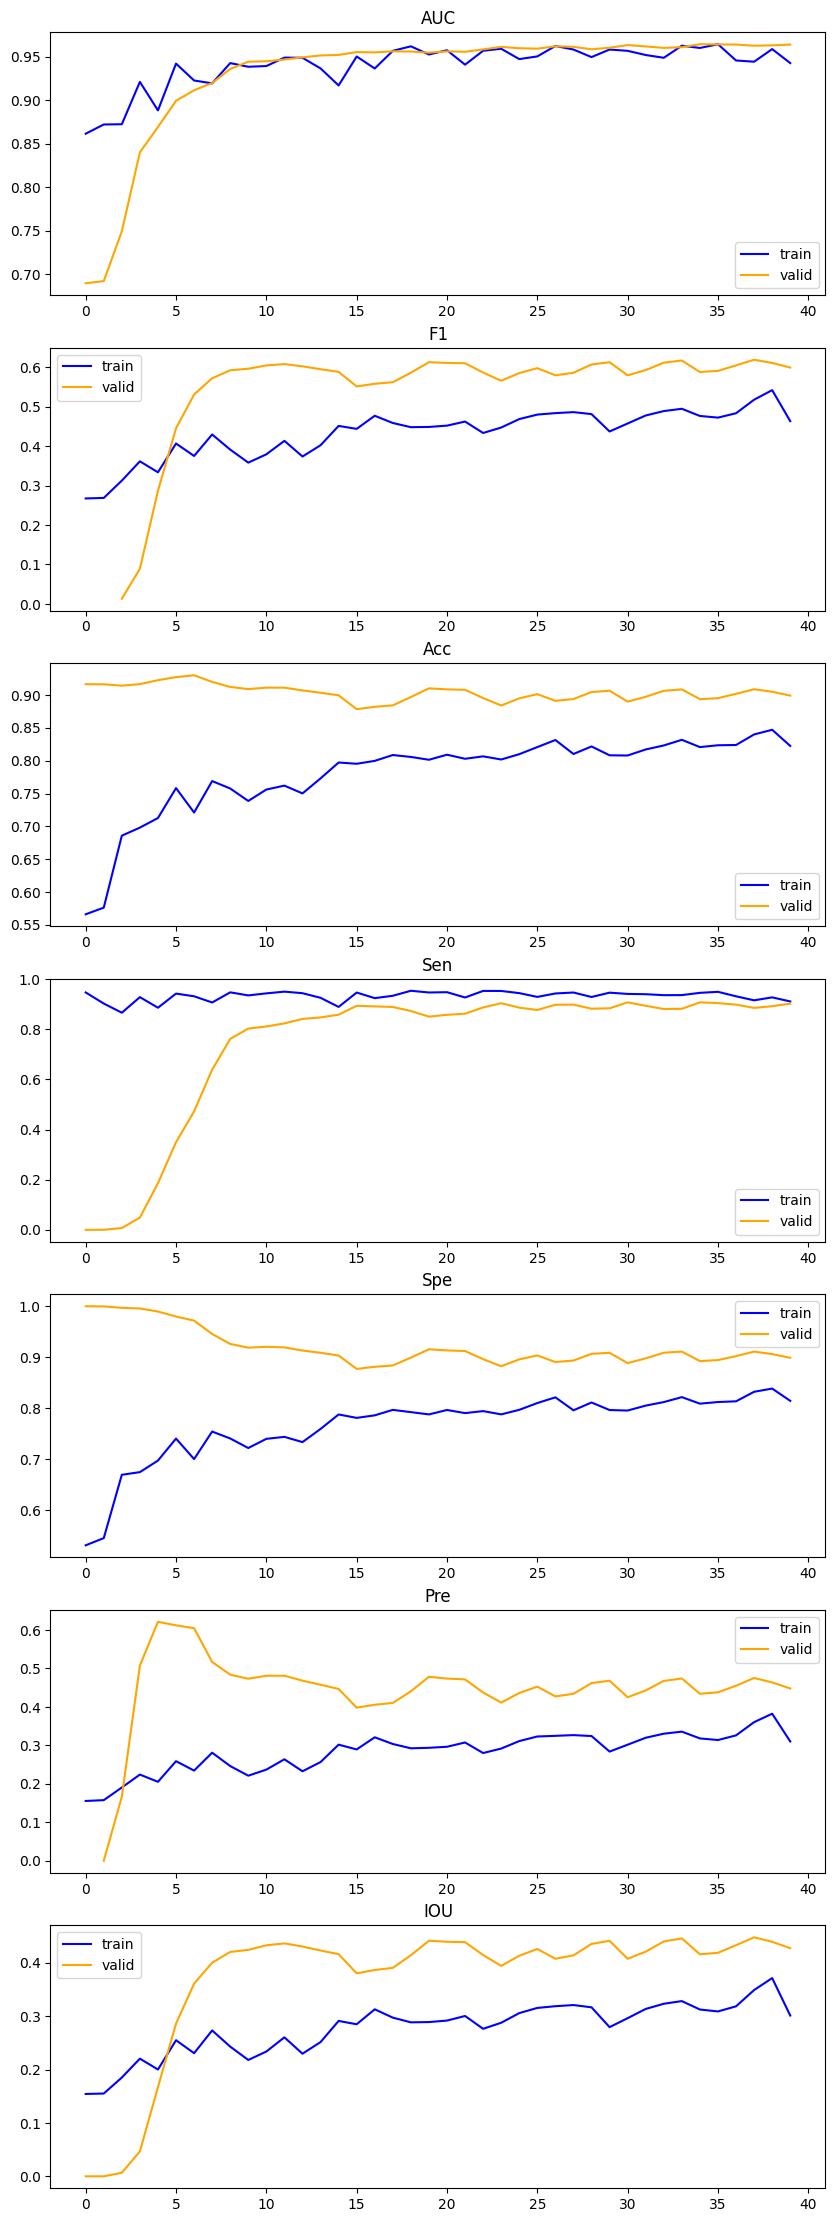

In [ ]:
fig, axs = plt.subplots(7,1, figsize=(10,28))
for i, (k,v) in enumerate(train_metric_hist.items()):
  axs[i].plot(v, c='b', label='train');axs[i].set_title(k)
for i, (k,v) in enumerate(valid_metric_hist.items()):
  axs[i].plot(v, c='orange', label='valid')
  axs[i].legend()
# fig.savefig('figs/FR-Unet-finetuned-metrics.png')

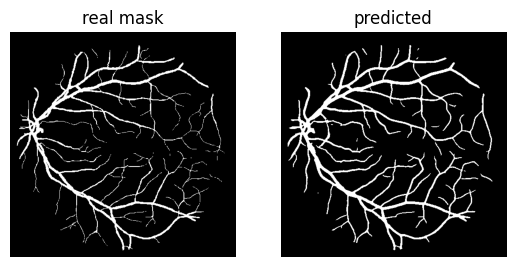

In [ ]:
im, mask = next(iter(train_dataset))
pred = model(im.to(0)[None,...])

fig = plt.figure()
plt.subplot(1,2,1)
plt.imshow(mask[0],'gray');plt.axis(False);plt.title("real mask")
plt.subplot(1,2,2)
plt.imshow(pred[0,0].detach().cpu()>0.5, 'gray');plt.axis(False);plt.title('predicted')
plt.savefig("figs/frunet-patches-finetuned-traindata.png")

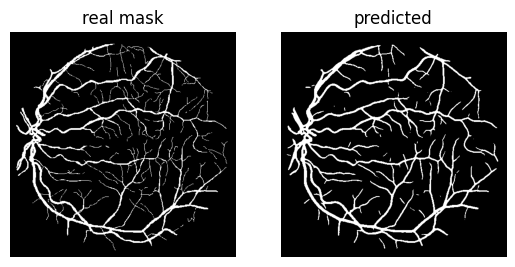

In [ ]:
im, mask = next(iter(test_dataset))
pred = model(im.to(0)[None,...])

fig = plt.figure()
plt.subplot(1,2,1)
plt.imshow(mask[0],'gray');plt.axis(False);plt.title("real mask")
plt.subplot(1,2,2)
plt.imshow(pred[0,0].detach().cpu()>0.5, 'gray');plt.axis(False);plt.title('predicted')
plt.savefig("figs/frunet-patches-finetuned-testdata.png")

In [ ]:
history = {'epoch': [], 'train_loss': [], 'valid_loss': [], "time": []}
test_metric_hist = {'AUC':[],'F1':[],'Acc':[],'Sen':[],'Spe':[],'Pre':[],'IOU':[]}
x_test, y_test, outputs_test, test_loss = evaluate(model, valid_loader, loss_fn, amp=True)
metric_test = get_metrics(predict=outputs_test, target=y_tr,threshold=0.5)
test_metric_hist = add_metric_history(metric_test, test_metric_hist)

In [ ]:
test_metric_hist

{'AUC': [0.5934],
 'F1': [0.1524],
 'Acc': [0.8373],
 'Sen': [0.184],
 'Spe': [0.8937],
 'Pre': [0.1301],
 'IOU': [0.0825]}

# Evaluation

In [ ]:
""" Seeding """
seeding(42)

""" Load dataset """
train_x = sorted(glob("./datasets/DRIVE/train-png/images/*"))
train_y = sorted(glob("./datasets/DRIVE/train-png/masks/*"))

test_x = sorted(glob("./datasets/DRIVE/test-png/images/*"))
test_y = sorted(glob("./datasets/DRIVE/test-png/masks/*"))

In [ ]:
""" Hyperparameters """
batch_size = 4

""" Dataset and loader """
train_dataset = DriveDataset(train_x, train_y)
test_dataset = DriveDataset(test_x, test_y)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)


print(f"Dataset Size:\n  Train: {len(train_loader)}\n  Test: {len(test_loader)}")

Dataset Size:
  Train: 5
  Test: 5


In [ ]:
model = model.to(0)
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
# loss_fn = DiceBCELoss()
loss_fn = DiceLoss()
scaler = torch.amp.GradScaler('cuda')

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
test = next(iter(test_loader))
train = next(iter(train_loader))

In [ ]:
def evaluate(model, loader, loss_fn, amp=False):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to("cuda", torch.float16)
            y = y.to("cuda", torch.float16)
            if amp:
                with torch.amp.autocast('cuda'):  # Enable mixed precision
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

            else:
                outputs = model(x)
                loss = loss_fn(outputs, y)



            epoch_loss += loss.item()

        epoch_loss = epoch_loss/(len(loader))
    return x,y, outputs, epoch_loss

def evaluate_all_models(model_path, model_name):
  """load pre-trained model"""
  checkpoint = torch.load(model_path)
  model.load_state_dict(checkpoint['model'])
  x_test, y_test, outputs_test, test_loss = evaluate(model, test_loader, loss_fn, amp=True)
  metric_test = get_metrics(predict=outputs_test, target=y_test,threshold=0.5)
  x_tr, y_tr, outputs_tr, train_loss = evaluate(model, train_loader, loss_fn, True)
  metric_train = get_metrics(predict=outputs_tr, target=y_tr,threshold=0.5)

  print(f"\t\t\t{model_name}")
  print(f"TRAIN:\n\tLoss: {train_loss}\n\tAUC: {metric_train['AUC']}\n\tIOU: {metric_train['IOU']}")
  print("-"*40)
  print(f"TEST:\n\tLoss: {test_loss}\n\tAUC: {metric_test['AUC']}\n\tIOU: {metric_test['IOU']}")

  pred_tr = model(train[0].to(0)).detach().cpu()
  pred_test = model(test[0].to(0)).detach().cpu()
  torch.cuda.empty_cache()
  f, axs = plt.subplots(4,6)
  for i, ax_row in enumerate(axs):
    ax_row[0].imshow(train[0][i][0].to('cpu'), 'gray');ax_row[0].axis(False) # original
    ax_row[1].imshow(pred_tr[i,0].detach().cpu()>0.5, 'gray');ax_row[1].axis(False)
    ax_row[2].imshow(train[1][i][0].to('cpu'), 'gray');ax_row[2].axis(False)
    ax_row[3].imshow(test[0][i][0].to('cpu'), 'gray');ax_row[3].axis(False)
    ax_row[4].imshow(pred_test[i,0]>0.5, 'gray');ax_row[4].axis(False)
    ax_row[5].imshow(test[1][i][0].to('cpu'), 'gray');ax_row[5].axis(False)
  axs[0,0].set_title("Original Train Image", fontsize=5)
  axs[0,1].set_title("Predicted Train Mask", fontsize=5)
  axs[0,2].set_title("Original Train Mask", fontsize=5)
  axs[0,3].set_title("Original Test Image", fontsize=5)
  axs[0,4].set_title("Predicted Test Mask", fontsize=5)
  axs[0,5].set_title("Original Test Mask", fontsize=5)
  f.savefig(f"figs/{model_name}.png")
  plt.show()

<ipython-input-23-8ef92129c010>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


			FR-Unet - augmented
TRAIN:
	Loss: 0.1639781951904297
	AUC: 0.9398
	IOU: 0.7061
----------------------------------------
TEST:
	Loss: 0.17882661819458007
	AUC: 0.9515
	IOU: 0.7071


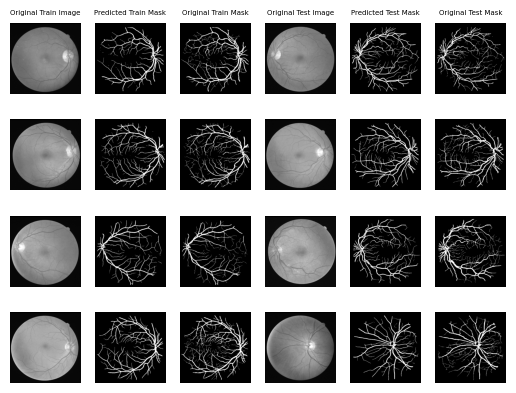

In [ ]:
evaluate_all_models("models/frunet_last_epoch.pth", "FR-Unet - augmented")

<ipython-input-17-8ef92129c010>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


			FR-Unet - random patches - finetuned
TRAIN:
	Loss: 0.437614643573761
	AUC: 0.9862
	IOU: 0.6227
----------------------------------------
TEST:
	Loss: 0.4474613666534424
	AUC: 0.9849
	IOU: 0.6087


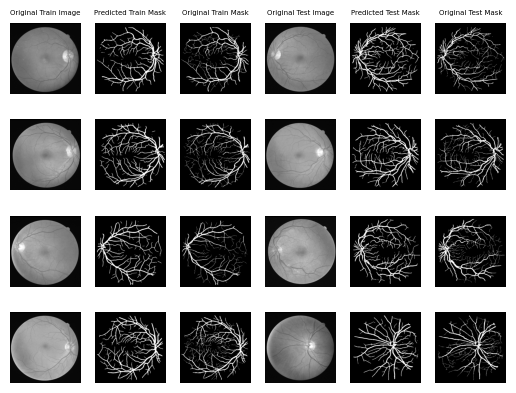

In [ ]:
evaluate_all_models("models/frunet-random-patches-finetuned.pth", "FR-Unet - random patches - finetuned")

<ipython-input-17-8ef92129c010>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


			FR-Unet - patches - finetuned
TRAIN:
	Loss: 0.43092472553253175
	AUC: 0.983
	IOU: 0.6315
----------------------------------------
TEST:
	Loss: 0.44142853021621703
	AUC: 0.984
	IOU: 0.6219


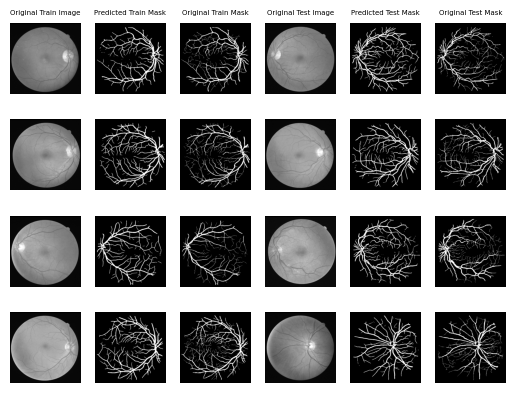

In [ ]:
evaluate_all_models("models/frunet_last_epoch_patches-finetuned.pth", "FR-Unet - patches - finetuned")

<ipython-input-17-8ef92129c010>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


			FR-Unet - patches
TRAIN:
	Loss: 0.4909147143363953
	AUC: 0.9824
	IOU: 0.6374
----------------------------------------
TEST:
	Loss: 0.4934645414352417
	AUC: 0.9842
	IOU: 0.5812


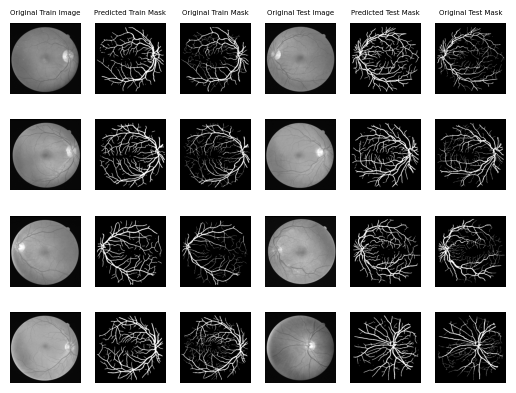

In [ ]:
evaluate_all_models("models/frunet_last_epoch_patches.pth", "FR-Unet - patches")

<ipython-input-17-8ef92129c010>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


			FR-Unet - random patches
TRAIN:
	Loss: 0.17938374280929564
	AUC: 0.9782
	IOU: 0.77
----------------------------------------
TEST:
	Loss: 0.23507115840911866
	AUC: 0.9575
	IOU: 0.68


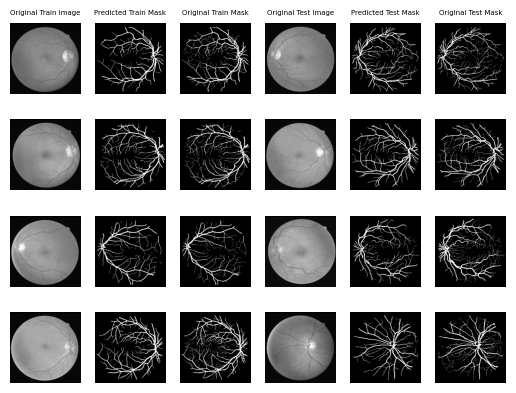

In [ ]:
evaluate_all_models("models/frunet_last_epoch_image_random_patches_120.pth", "FR-Unet - random patches")

<ipython-input-28-8ef92129c010>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


			FR-Unet - withou anything
TRAIN:
	Loss: 0.6453725218772888
	AUC: 0.959
	IOU: 0.3556
----------------------------------------
TEST:
	Loss: 0.6387890338897705
	AUC: 0.9721
	IOU: 0.4167


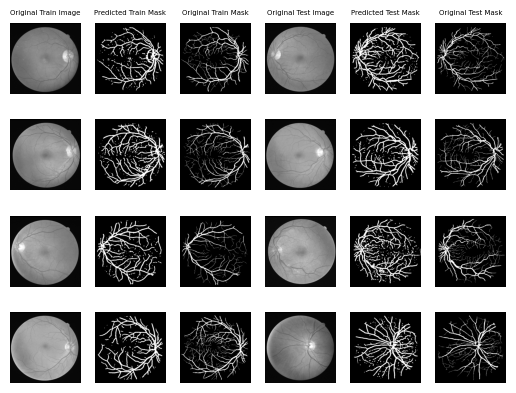

In [ ]:
evaluate_all_models("models/frunet-without-anything-40.pth", "FR-Unet - withou anything")

# Save predict test

In [ ]:
def evaluate(model, loader, loss_fn, amp=False):
  epoch_loss = 0.0

  model.eval()
  with torch.no_grad():
      for x, y in loader:
          x = x.to("cuda", torch.float16)
          y = y.to("cuda", torch.float16)
          if amp:
              with torch.amp.autocast('cuda'):  # Enable mixed precision
                  outputs = model(x)
                  loss = loss_fn(outputs, y)

          else:
              outputs = model(x)
              loss = loss_fn(outputs, y)



          epoch_loss += loss.item()

      epoch_loss = epoch_loss/(len(loader))
  return x,y, outputs, epoch_loss

model_path = "models/frunet-random-patches-finetuned.pth"
# model_path = "models/frunet_last_epoch.pth"
model_path = "models/frunet_last_epoch_patches.pth"
model_path = "models/frunet-without-anything-40.pth"
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model'])
x_test, y_test, outputs_test, test_loss = evaluate(model, test_loader, loss_fn, amp=True)
metric_test = get_metrics(predict=outputs_test, target=y_test,threshold=0.5)
x_tr, y_tr, outputs_tr, train_loss = evaluate(model, train_loader, loss_fn, True)
metric_train = get_metrics(predict=outputs_tr, target=y_tr,threshold=0.5)

<ipython-input-19-684a1452b390>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [ ]:
predicteds = []
xs = []
ys = []
for x,y in train_loader:
  pred = model(x.to(0)).detach().cpu()>0.5
  torch.cuda.empty_cache()
  predicteds.append(pred)
  xs.append(x)
  ys.append(y)

In [ ]:
def unnorm(im):
  return np.uint8(255*(im-im.min())/(im.max()-im.min()))

In [ ]:
im[...,0].shape
pred[0,0].shape

torch.Size([512, 512])

In [ ]:
np.array([x[0,0],x[0,0],x[0,0]]).transpose(1,2,0).shape

(512, 512, 3)

## patches

(-0.5, 69.5, 69.5, -0.5)

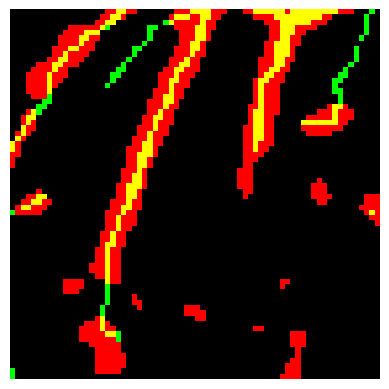

In [ ]:
im = np.zeros((512,512,3))
# im = np.array([x[0,0],x[0,0],x[0,0]]).transpose(1,2,0) # 0, 3, 0 moiraga
im[...,0] = np.array(predicteds[1][3,0])
im[...,1] = np.array(ys[1][3,0])

plt.imshow(im[200:270,200:270], 'gray');plt.axis(False)
# plt.imshow(im[150:250,25:125], 'gray');plt.axis(False)
# plt.imshow(im, 'gray');plt.axis(False)


## random patches finetuned

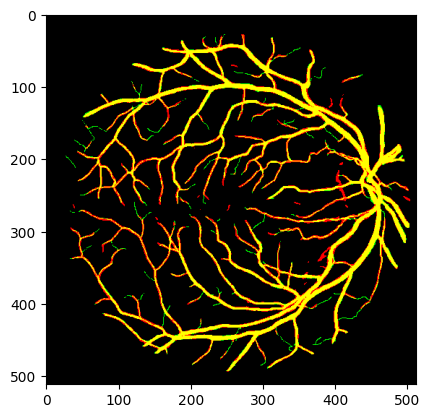

In [ ]:
im = np.zeros((512,512,3))
# im = np.array([x[0,0],x[0,0],x[0,0]]).transpose(1,2,0) # 0, 3, 0 moiraga
im[...,0] = np.array(predicteds[1][3,0])
im[...,1] = np.array(ys[1][3,0])

# plt.imshow(im[200:270,200:270], 'gray');plt.axis(False)
plt.imshow(im, 'gray')#;plt.axis(False)

(-0.5, 511.5, 511.5, -0.5)

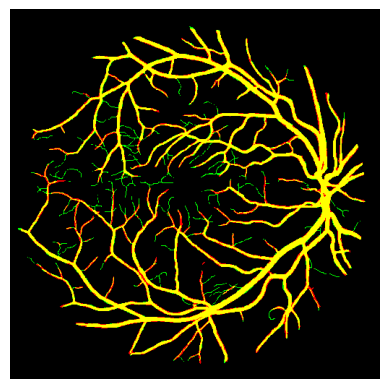

In [ ]:
im = np.zeros((512,512,3))
# im = np.array([x[0,0],x[0,0],x[0,0]]).transpose(1,2,0)
im[...,0] = np.array(predicteds[4][3,0])
im[...,1] = np.array(ys[4][3,0])
# augmented
plt.imshow(im, 'gray');plt.axis(False)

(-0.5, 511.5, 511.5, -0.5)

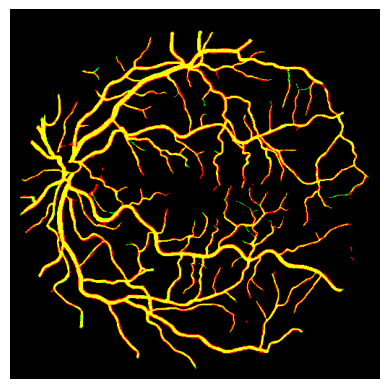

In [ ]:
im = np.zeros((512,512,3))
# im = np.array([x[0,0],x[0,0],x[0,0]]).transpose(1,2,0) # 0, 1,0
im[...,0] = np.array(predicteds[0][1,0])
im[...,1] = np.array(ys[0][1,0])

plt.imshow(im, 'gray');plt.axis(False)

## augmented

(-0.5, 99.5, 99.5, -0.5)

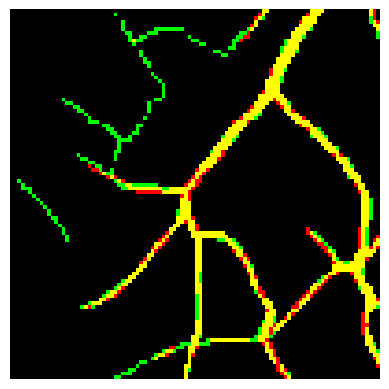

In [ ]:
im = np.zeros((512,512,3))
# im = np.array([x[0,0],x[0,0],x[0,0]]).transpose(1,2,0) # 0, 3, 0 moiraga
im[...,0] = np.array(predicteds[1][3,0])
im[...,1] = np.array(ys[1][3,0])

# plt.imshow(im, 'gray')#;plt.axis(False)
plt.imshow(im[150:250,25:125], 'gray');plt.axis(False)

In [ ]:
im.max()

0

In [ ]:

pred_tr = model(train[0].to(0)).detach().cpu()
pred_test = model(test[0].to(0)).detach().cpu()
torch.cuda.empty_cache()
f, axs = plt.subplots(4,6)
for i, ax_row in enumerate(axs):
  ax_row[0].imshow(train[0][i][0].to('cpu'), 'gray');ax_row[0].axis(False) # original
  ax_row[1].imshow(pred_tr[i,0].detach().cpu()>0.5, 'gray');ax_row[1].axis(False)
  ax_row[2].imshow(train[1][i][0].to('cpu'), 'gray');ax_row[2].axis(False)
  ax_row[3].imshow(test[0][i][0].to('cpu'), 'gray');ax_row[3].axis(False)
  ax_row[4].imshow(pred_test[i,0]>0.5, 'gray');ax_row[4].axis(False)
  ax_row[5].imshow(test[1][i][0].to('cpu'), 'gray');ax_row[5].axis(False)
axs[0,0].set_title("Original Train Image", fontsize=5)
axs[0,1].set_title("Predicted Train Mask", fontsize=5)
axs[0,2].set_title("Original Train Mask", fontsize=5)
axs[0,3].set_title("Original Test Image", fontsize=5)
axs[0,4].set_title("Predicted Test Mask", fontsize=5)
axs[0,5].set_title("Original Test Mask", fontsize=5)
f.savefig(f"figs/{model_name}.png")
plt.show()

tensor([[[[-1.8820, -2.1127, -2.1223,  ..., -2.1351, -2.0361, -1.7586],
          [-2.1621, -2.5132, -2.5336,  ..., -2.5242, -2.4135, -2.0467],
          [-2.2015, -2.5782, -2.5654,  ..., -2.5548, -2.4927, -2.1195],
          ...,
          [-2.1354, -2.4534, -2.4958,  ..., -2.5207, -2.4349, -2.1023],
          [-2.0351, -2.3454, -2.4104,  ..., -2.4547, -2.3612, -2.0281],
          [-1.7704, -2.0151, -2.0855,  ..., -2.1338, -2.0589, -1.8316]]],


        [[[-1.8819, -2.1121, -2.1220,  ..., -2.1349, -2.0368, -1.7589],
          [-2.1617, -2.5133, -2.5337,  ..., -2.5235, -2.4134, -2.0472],
          [-2.2018, -2.5780, -2.5653,  ..., -2.5536, -2.4918, -2.1191],
          ...,
          [-2.1344, -2.4529, -2.4956,  ..., -2.5194, -2.4299, -2.1008],
          [-2.0352, -2.3446, -2.4100,  ..., -2.4532, -2.3592, -2.0285],
          [-1.7700, -2.0150, -2.0853,  ..., -2.1344, -2.0599, -1.8335]]],


        [[[-1.8820, -2.1123, -2.1217,  ..., -2.1343, -2.0351, -1.7572],
          [-2.1621, -2.513